# Emergency Vehicle Dataset Exploration

This notebook explores the emergency vehicle dataset to understand its characteristics and prepare it for training.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from PIL import Image
import torch

## 1. Dataset Structure Analysis

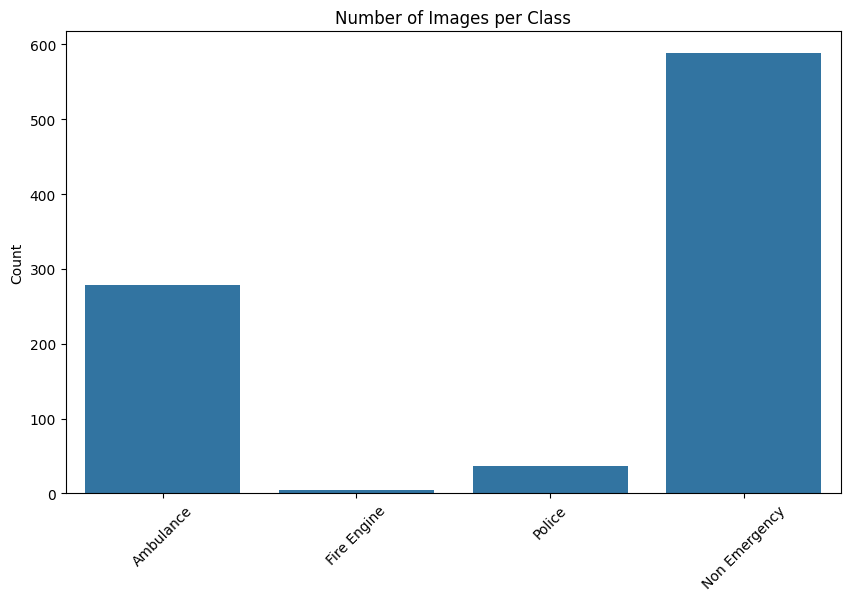

In [2]:
# Dataset paths
DATASET_ROOT = Path('../Dataset')
classes = ['Ambulance', 'Fire Engine', 'Police', 'Non Emergency']

# Count images per class
class_counts = {}
for class_name in classes:
    class_path = DATASET_ROOT / class_name
    if class_path.exists():
        n_images = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
        class_counts[class_name] = n_images

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

## 2. Image Statistics

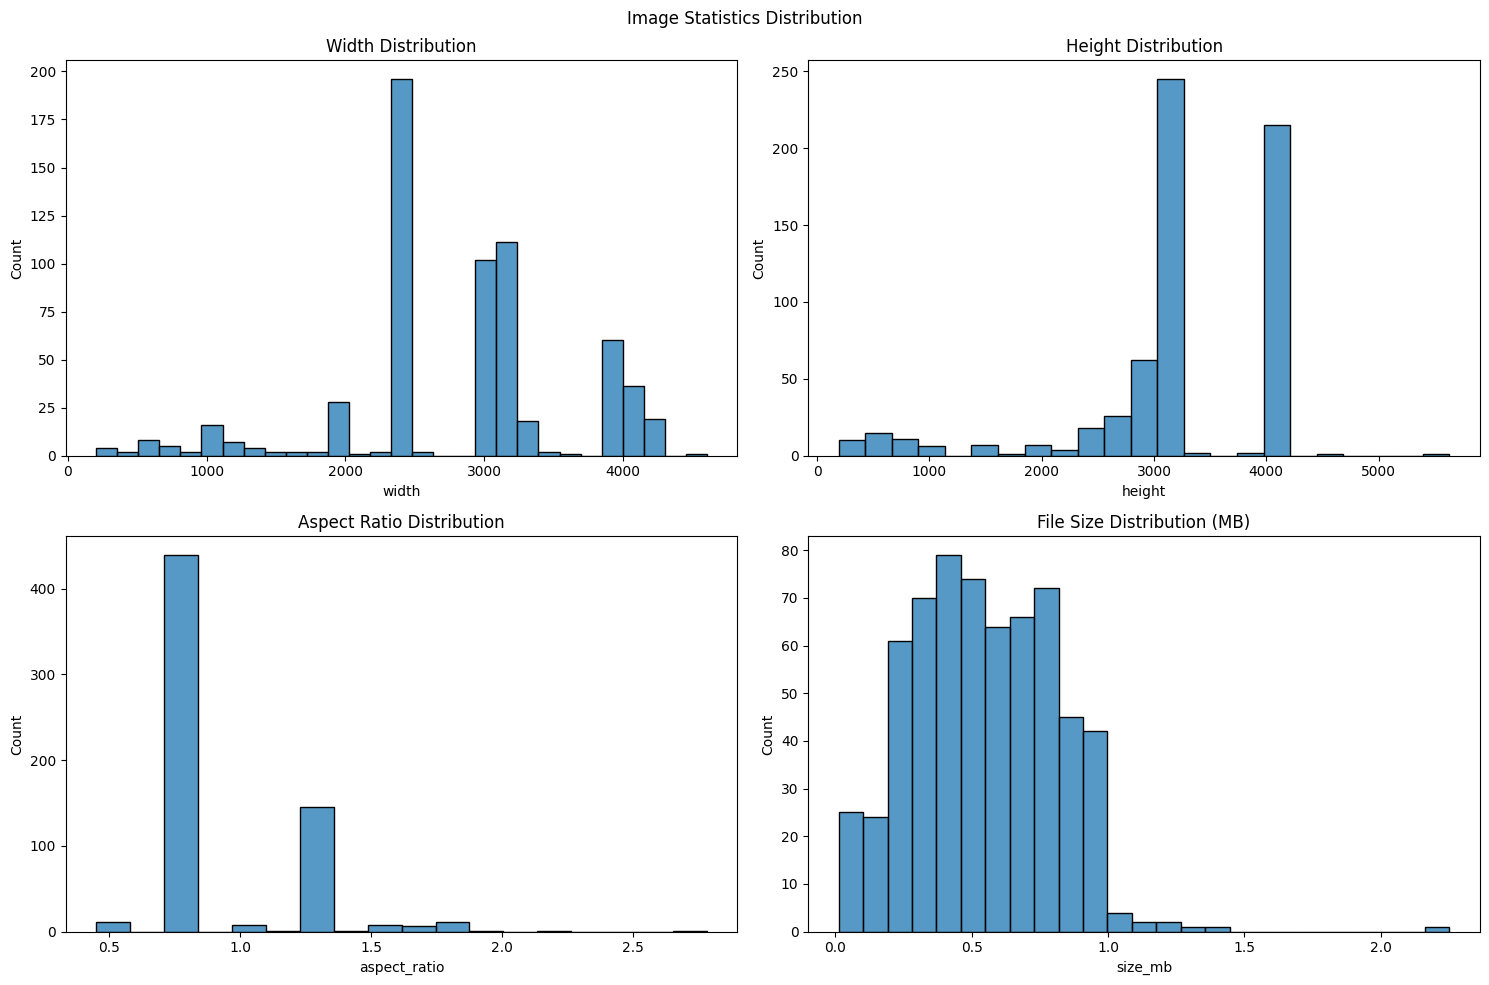

In [3]:
def get_image_stats(image_path):
    """Get basic statistics for an image"""
    img = cv2.imread(str(image_path))
    return {
        'height': img.shape[0],
        'width': img.shape[1],
        'aspect_ratio': img.shape[1] / img.shape[0],
        'size_mb': os.path.getsize(image_path) / (1024 * 1024)
    }

# Collect stats for all images
stats = []
for class_name in classes:
    class_path = DATASET_ROOT / class_name
    if class_path.exists():
        for img_path in class_path.glob('*.jpg'):
            try:
                img_stats = get_image_stats(img_path)
                img_stats['class'] = class_name
                stats.append(img_stats)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

stats_df = pd.DataFrame(stats)

# Plot size distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Image Statistics Distribution')

sns.histplot(data=stats_df, x='width', ax=axes[0,0])
axes[0,0].set_title('Width Distribution')

sns.histplot(data=stats_df, x='height', ax=axes[0,1])
axes[0,1].set_title('Height Distribution')

sns.histplot(data=stats_df, x='aspect_ratio', ax=axes[1,0])
axes[1,0].set_title('Aspect Ratio Distribution')

sns.histplot(data=stats_df, x='size_mb', ax=axes[1,1])
axes[1,1].set_title('File Size Distribution (MB)')

plt.tight_layout()
plt.show()

## 3. Sample Visualization

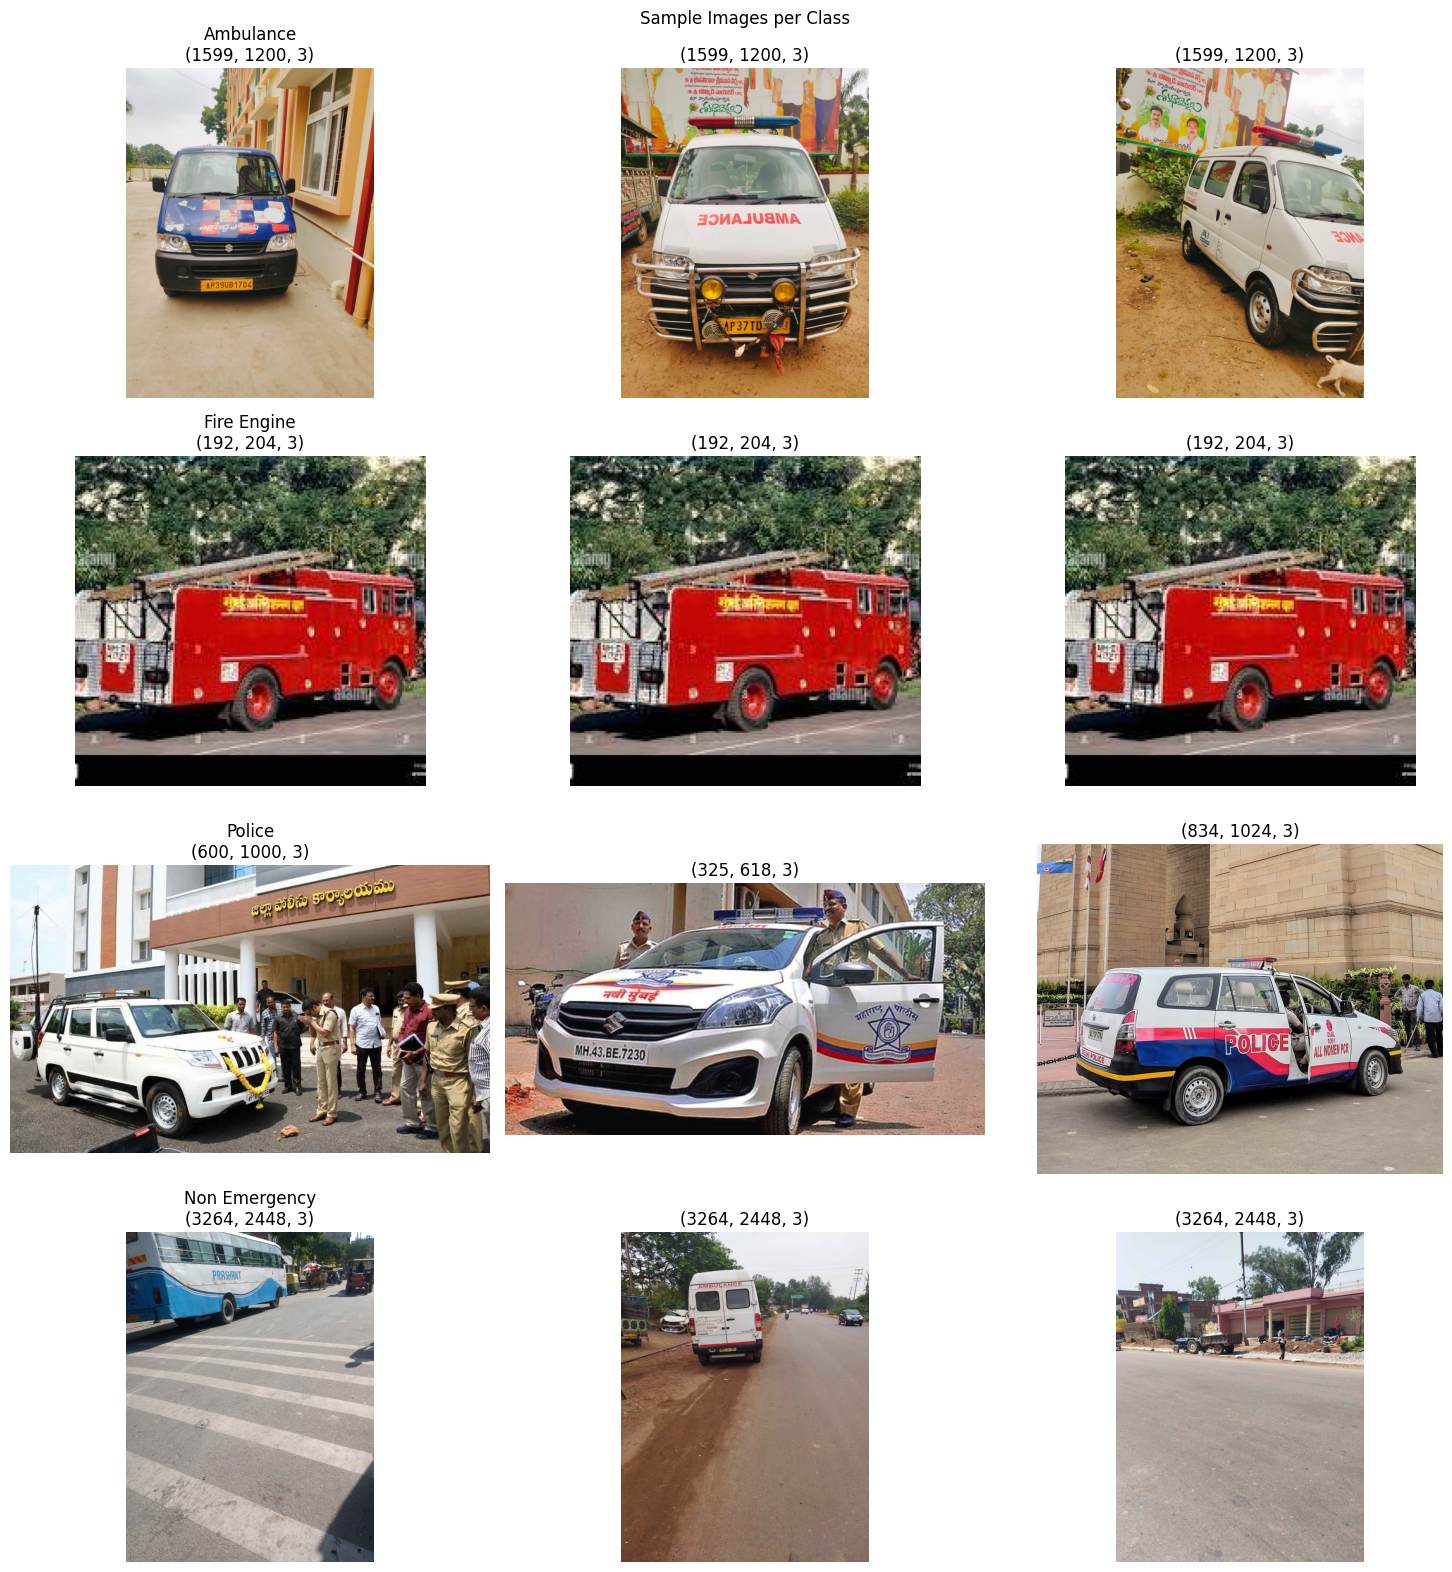

In [4]:
def plot_sample_images(n_per_class=3):
    """Plot sample images from each class"""
    fig, axes = plt.subplots(len(classes), n_per_class, figsize=(15, 4*len(classes)))
    fig.suptitle('Sample Images per Class')
    
    for i, class_name in enumerate(classes):
        class_path = DATASET_ROOT / class_name
        if class_path.exists():
            image_paths = list(class_path.glob('*.jpg'))[:n_per_class]
            for j, img_path in enumerate(image_paths):
                try:
                    img = cv2.imread(str(img_path))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axes[i,j].imshow(img)
                    axes[i,j].axis('off')
                    if j == 0:
                        axes[i,j].set_title(f'{class_name}\n{img.shape}')
                    else:
                        axes[i,j].set_title(f'{img.shape}')
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

plot_sample_images()

## 4. Image Quality Analysis

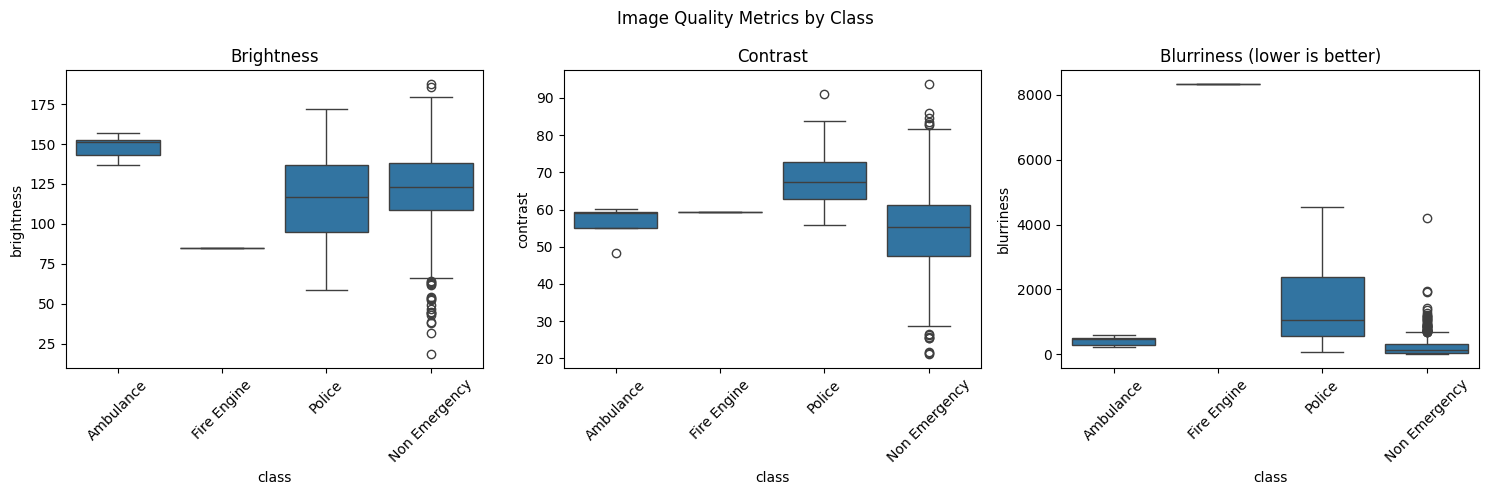

In [5]:
def analyze_image_quality(image_path):
    """Basic image quality metrics"""
    img = cv2.imread(str(image_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return {
        'brightness': np.mean(gray),
        'contrast': np.std(gray),
        'blurriness': cv2.Laplacian(gray, cv2.CV_64F).var()
    }

# Collect quality metrics
quality_stats = []
for class_name in classes:
    class_path = DATASET_ROOT / class_name
    if class_path.exists():
        for img_path in class_path.glob('*.jpg'):
            try:
                stats = analyze_image_quality(img_path)
                stats['class'] = class_name
                quality_stats.append(stats)
            except Exception as e:
                print(f"Error analyzing {img_path}: {e}")

quality_df = pd.DataFrame(quality_stats)

# Plot quality distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Image Quality Metrics by Class')

sns.boxplot(data=quality_df, x='class', y='brightness', ax=axes[0])
axes[0].set_title('Brightness')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=quality_df, x='class', y='contrast', ax=axes[1])
axes[1].set_title('Contrast')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(data=quality_df, x='class', y='blurriness', ax=axes[2])
axes[2].set_title('Blurriness (lower is better)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Data Preprocessing Requirements

Based on the analysis above, here are the preprocessing steps needed:

1. Image Resizing:
   - Standardize all images to 640x640 (YOLOv8 input size)
   - Maintain aspect ratio by padding

2. Class Balance:
   - Apply data augmentation for underrepresented classes
   - Consider weighted loss during training

3. Quality Improvements:
   - Filter out extremely blurry images
   - Apply contrast enhancement where needed
   - Consider brightness normalization

4. Dataset Split:
   - 70% training
   - 15% validation
   - 15% testing